In [151]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE

In [152]:
# 1. Read the dfset
df = pd.read_csv('bank.csv')
print(df.head())
df

    age   marital  education default  balance housing loan  contact poutcome  \
0  35.0   married   tertiary      no    231.0     yes   no  unknown  unknown   
1  50.0   married  secondary      no     49.0     yes   no  unknown  unknown   
2  44.0   married  secondary      no      0.0     yes   no  unknown  unknown   
3  55.0  divorced  secondary      no      0.0      no   no  unknown  unknown   
4  42.0    single  secondary      no    -76.0     yes   no  unknown  unknown   

    y  
0  no  
1  no  
2  no  
3  no  
4  no  


,age,marital,education,default,balance,housing,loan,contact,poutcome,y
0,35.000000,married,tertiary,no,231.000000,yes,no,unknown,unknown,no
1,50.000000,married,secondary,no,49.000000,yes,no,unknown,unknown,no
2,44.000000,married,secondary,no,0.000000,yes,no,unknown,unknown,no
3,55.000000,divorced,secondary,no,0.000000,no,no,unknown,unknown,no
4,42.000000,single,secondary,no,-76.000000,yes,no,unknown,unknown,no
...,...,...,...,...,...,...,...,...,...,...
7345,34.520042,single,secondary,yes,9.915360,yes,unknown,cellular,failure,unknown
7346,29.424579,divorced,primary,unknown,907.394278,no,no,unknown,failure,yes
7347,35.574229,unknown,tertiary,no,1037.272121,unknown,no,cellular,unknown,yes
7348,22.433373,single,secondary,no,334.732661,unknown,no,unknown,unknown,no


In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7350 entries, 0 to 7349
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        7350 non-null   float64
 1   marital    7350 non-null   object 
 2   education  7350 non-null   object 
 3   default    7350 non-null   object 
 4   balance    7350 non-null   float64
 5   housing    7350 non-null   object 
 6   loan       7350 non-null   object 
 7   contact    7350 non-null   object 
 8   poutcome   7350 non-null   object 
 9   y          7350 non-null   object 
dtypes: float64(2), object(8)
memory usage: 574.3+ KB


In [154]:
print(df.nunique())

age           425
marital         4
education       4
default         3
balance      3407
housing         3
loan            3
contact         3
poutcome        4
y               3
dtype: int64


In [155]:
for col in df.select_dtypes(include='object').columns:
    print(df[col].value_counts())
    print()

marital
married     4040
single      2303
divorced     909
unknown       98
Name: count, dtype: int64

education
secondary    3516
tertiary     2386
primary       993
unknown       455
Name: count, dtype: int64

default
no         7023
yes         214
unknown     113
Name: count, dtype: int64

housing
no         3813
yes        3424
unknown     113
Name: count, dtype: int64

loan
no         6244
yes         984
unknown     122
Name: count, dtype: int64

contact
cellular     5188
unknown      1611
telephone     551
Name: count, dtype: int64

poutcome
unknown    5333
failure     852
success     751
other       414
Name: count, dtype: int64

y
no         3622
yes        3613
unknown     115
Name: count, dtype: int64



In [156]:
df.isnull().sum()

age          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
poutcome     0
y            0
dtype: int64

In [157]:
# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

df.drop_duplicates(inplace=True)

Number of duplicate rows: 114


In [158]:
# Check for negative values in 'age' and 'balance'
print("Negative values in 'age':", (df['age'] < 0).sum())
print("Negative values in 'balance':", (df['balance'] < 0).sum())

Negative values in 'age': 0
Negative values in 'balance': 576


In [159]:
# Analyze unknown proportions and print in decreasing order of percentage
def analyze_unknown_values(data):
    unknown_analysis = {}
    for col in data.columns:
        if data[col].dtype == 'object':
            total_count = len(data)
            unknown_count = (data[col] == 'unknown').sum()
            unknown_percentage = (unknown_count / total_count) * 100
            unknown_analysis[col] = {
                'unknown_count': unknown_count,
                'total_count': total_count,
                'unknown_percentage': unknown_percentage
            }
    return unknown_analysis

unknown_stats = analyze_unknown_values(df)
# Sort by unknown_percentage in decreasing order
sorted_stats = sorted(unknown_stats.items(), key=lambda x: x[1]['unknown_percentage'], reverse=True)
for col, stats in sorted_stats:
    print(f"{col}: {stats['unknown_count']} unknown ({stats['unknown_percentage']:.1f}%)")

poutcome: 5288 unknown (73.1%)
contact: 1606 unknown (22.2%)
education: 451 unknown (6.2%)
loan: 122 unknown (1.7%)
y: 115 unknown (1.6%)
default: 113 unknown (1.6%)
housing: 113 unknown (1.6%)
marital: 98 unknown (1.4%)


In [160]:
# Drop all rows where the target 'y' is 'unknown'
df = df[df['y'] != 'unknown'].copy()
df.reset_index(drop=True, inplace=True)

In [161]:
# Select only float columns
float_cols = df.select_dtypes(include=['float']).columns

for col in float_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    df = df[(df[col] >= lower) & (df[col] <= upper)]

# Reset index after filtering
df.reset_index(drop=True, inplace=True)


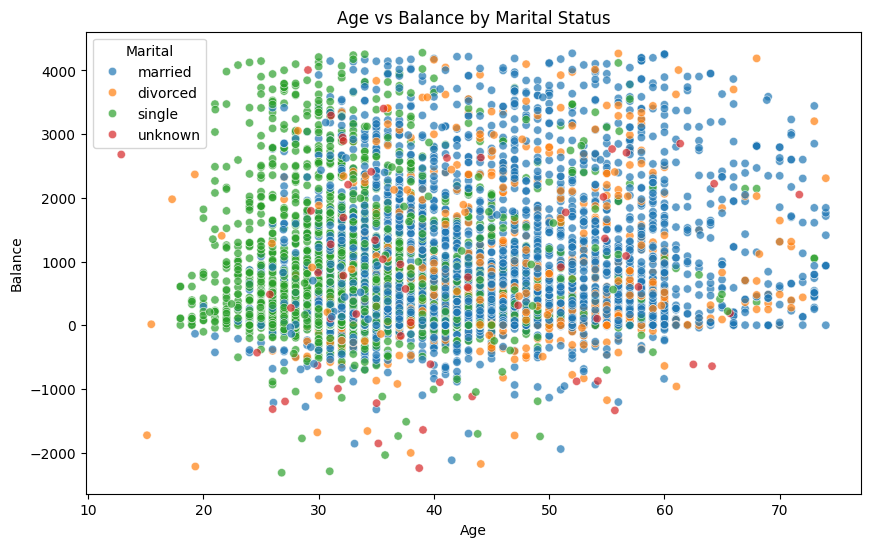

In [162]:

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='age', y='balance', hue='marital', alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Balance')
plt.title('Age vs Balance by Marital Status')
plt.legend(title='Marital')
plt.show()

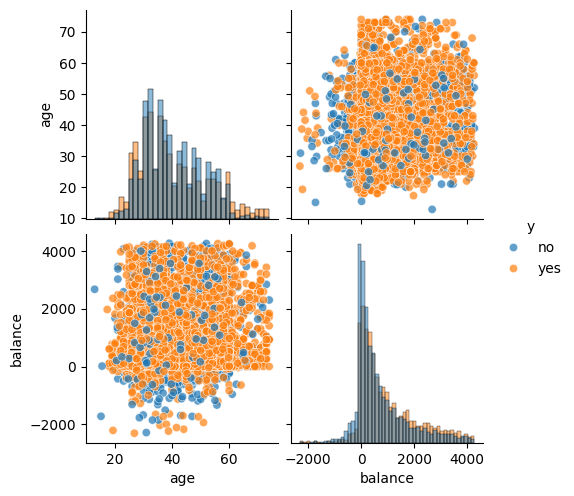

In [163]:
sns.pairplot(df, diag_kind='hist',  hue= 'y', 
             diag_kws={"edgecolor":"k", "alpha":0.5},
             plot_kws={"alpha":0.7})

In [164]:
x = df.drop(columns=['y'])
y = df['y'] 

In [165]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# MinMaxScaler is used because negative values are also available.
scaler = MinMaxScaler()
X_train["balance"] = scaler.fit_transform(X_train[['balance']])
X_test["balance"] = scaler.transform(X_test[['balance']])



standard_scaler = StandardScaler()
X_train["age"] = standard_scaler.fit_transform(X_train[['age']])
X_test["age"] = standard_scaler.transform(X_test[['age']])

In [167]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5086 entries, 6292 to 2164
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        5086 non-null   float64
 1   marital    5086 non-null   object 
 2   education  5086 non-null   object 
 3   default    5086 non-null   object 
 4   balance    5086 non-null   float64
 5   housing    5086 non-null   object 
 6   loan       5086 non-null   object 
 7   contact    5086 non-null   object 
 8   poutcome   5086 non-null   object 
dtypes: float64(2), object(7)
memory usage: 397.3+ KB


In [168]:
# 1. For features with low unknown: Replace with mode 
low_unknown_features = ['marital', 'default', 'housing', 'loan','education']
for col in low_unknown_features:
    mode_value = X_train[X_train[col] != 'unknown'][col].mode()
    if len(mode_value) > 0:
        X_train[col] = X_train[col].replace('unknown', mode_value[0])
        X_test[col] = X_test[col].replace('unknown', mode_value[0])
        print(f"Replaced {col} 'unknown' with mode: {mode_value[0]}")


# 3. For contact (22% unknown)
if 'contact' in X_train.columns:
    # Keep 'unknown' as a separate category as 'no_contact'
    X_train['contact'] = X_train['contact'].replace('unknown', 'no_contact')
    X_test['contact'] = X_test['contact'].replace('unknown', 'no_contact')
    print("Kept contact 'unknown' as separate category: 'no_contact'")


# 4. For poutcome (73% unknown)
if 'poutcome' in X_train.columns:
    # 'Unknown' in previous campaign outcome likely means no previous campaign
    X_train['poutcome'] = X_train['poutcome'].replace('unknown', 'none')
    X_test['poutcome'] = X_test['poutcome'].replace('unknown', 'none')
    print("Replaced poutcome 'unknown' with 'none'")

Replaced marital 'unknown' with mode: married
Replaced default 'unknown' with mode: no
Replaced housing 'unknown' with mode: no
Replaced loan 'unknown' with mode: no
Replaced education 'unknown' with mode: secondary
Kept contact 'unknown' as separate category: 'no_contact'
Replaced poutcome 'unknown' with 'none'


In [169]:

categorical_cols = X_train.select_dtypes(include=['object']).columns
encoders = {}
for col in categorical_cols:
    labelencoder = LabelEncoder()
    X_train[col] = labelencoder.fit_transform(X_train[col])
    X_test[col] = labelencoder.transform(X_test[col])
    encoders[col] = labelencoder
    print(f"Encoded {col} with LabelEncoder:")
    for class_label, encoded_value in zip(labelencoder.classes_, range(len(labelencoder.classes_))):
        print(f"{class_label} → {encoded_value}")
    
y_train = labelencoder.fit_transform(y_train)
y_test = labelencoder.transform(y_test)


Encoded marital with LabelEncoder:
divorced → 0
married → 1
single → 2
Encoded education with LabelEncoder:
primary → 0
secondary → 1
tertiary → 2
Encoded default with LabelEncoder:
no → 0
yes → 1
Encoded housing with LabelEncoder:
no → 0
yes → 1
Encoded loan with LabelEncoder:
no → 0
yes → 1
Encoded contact with LabelEncoder:
cellular → 0
no_contact → 1
telephone → 2
Encoded poutcome with LabelEncoder:
failure → 0
none → 1
other → 2
success → 3


In [170]:
X_train 

,age,marital,education,default,balance,housing,loan,contact,poutcome
6292,0.812833,0,2,0,0.276315,1,0,2,2
5275,-1.024606,2,2,0,0.420173,0,0,2,3
5856,-0.575153,1,0,0,0.351164,1,1,0,1
1335,1.762002,1,1,0,0.351164,0,0,0,1
4203,-0.844825,1,2,0,0.553034,0,0,0,3
...,...,...,...,...,...,...,...,...,...
2443,-0.934715,2,2,0,0.977401,0,0,0,1
5450,-0.665044,1,1,0,0.424571,1,0,0,3
2442,-0.395372,2,2,0,0.495704,1,0,0,0
31,-1.474059,2,1,0,0.351164,1,0,1,1


In [171]:
X_test

,age,marital,education,default,balance,housing,loan,contact,poutcome
5890,-0.934715,2,2,0,0.858190,0,0,0,1
452,-0.844825,2,0,0,0.283975,1,0,1,1
1996,-1.474059,2,1,0,0.410769,1,1,0,1
4620,-0.934715,2,1,0,0.740496,0,0,0,1
2565,1.222658,1,1,0,0.209809,1,0,1,1
...,...,...,...,...,...,...,...,...,...
5962,0.413643,2,2,0,0.565168,0,0,0,0
828,1.582221,1,0,0,0.369971,1,0,0,1
3523,0.593424,2,1,0,0.518150,1,0,0,1
2385,-1.474059,2,1,0,0.416988,0,0,0,1


In [172]:
for col in X_test.select_dtypes(include='object').columns:
    print(X_test[col].value_counts())
    print()

In [ ]:

params = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2']
}


dt_grid_search = GridSearchCV(DecisionTreeClassifier(), params, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)

dt_grid_search.fit(X_train, y_train)
y_pred_dt = dt_grid_search.predict(X_test)

print(f"Best parameters: {dt_grid_search.best_params_}")
print(f"Best score: {dt_grid_search.best_score_:.4f}")


print('DecisionTreeClassifier Accuracy: %.5f' % accuracy_score(y_test, y_pred_dt))

print('DecisionTreeClassifier Train Score is : ' , dt_grid_search.score(X_train, y_train))
print('DecisionTreeClassifier Test Score is : ' , dt_grid_search.score(X_test, y_test))
y_pred_labels = labelencoder.inverse_transform(y_pred_dt)
y_test_labels = labelencoder.inverse_transform(y_test)



print(classification_report(y_test_labels, y_pred_labels, target_names=labelencoder.classes_))


Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2}
Best score: 0.6486
DecisionTreeClassifier Accuracy: 0.67531
DecisionTreeClassifier Train Score is :  0.6599862411945245
DecisionTreeClassifier Test Score is :  0.668298017564541
              precision    recall  f1-score   support

          no       0.65      0.80      0.72       653
         yes       0.72      0.54      0.62       619

    accuracy                           0.68      1272
   macro avg       0.68      0.67      0.67      1272
weighted avg       0.68      0.68      0.67      1272



In [178]:
# Train Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)

# Predict
y_pred_nb = nb.predict(X_test)

# Results
print('Naive Bayes Accuracy: %.5f' % accuracy_score(y_test, y_pred_nb))

print('Naive Bayes Train Score is : ' , nb.score(X_train, y_train))
print('Naive Bayes Test Score is : ' , nb.score(X_test, y_test))
print(classification_report(y_test, y_pred_nb, target_names=labelencoder.classes_))

Naive Bayes Accuracy: 0.65566
Naive Bayes Train Score is :  0.6476602438065278
Naive Bayes Test Score is :  0.6556603773584906
              precision    recall  f1-score   support

          no       0.66      0.68      0.67       653
         yes       0.65      0.63      0.64       619

    accuracy                           0.66      1272
   macro avg       0.66      0.65      0.65      1272
weighted avg       0.66      0.66      0.66      1272



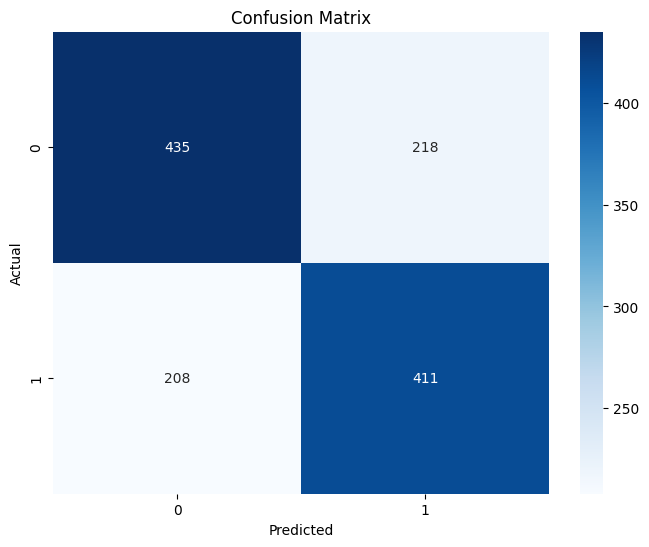

In [175]:
# Visualize confusion matrix

conf_matrix = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

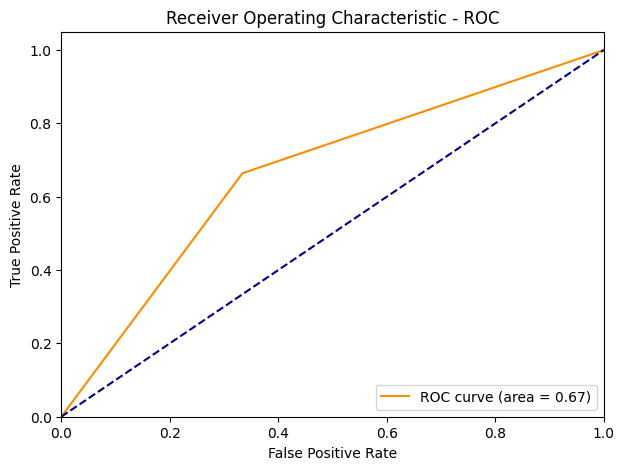

In [176]:

from sklearn.metrics import roc_curve, auc, roc_auc_score

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_dt)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='navy', linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - ROC')
plt.legend(loc="lower right")
plt.show()